# 1. 决策树的构造

优点：计算复杂度不高，输出结果易于理解，对中间值缺失不敏感，可以处理不相关特征数据

缺点：可能会产生过度匹配的问题

适用数据类型：数值型和标称型

创建分支的伪代码函数createBranch()如下所示：

检测数据集中的每个子项是否属于同一分类：

    If so return 类标签；
    Else
       寻找划分数据集的最好特征
       划分数据集
       创建分支节点
           for 每个划分的子集
               调用函数createBranch并增加返回结果到分支节点中
       return 分支节点
       
决策树的一般流程：

（1）收集数据：可以使用任何方法

（2）准备数据：树构造算法只适用于标称型数据，因此数值型数据必须离散化

（3）分析数据：可以使用任何方法，构造树完成之后，我们应该检查图形是否符合预期

（4）训练算法：构造树的数据结构

（5）测试算法：使用经验树计算错误率

（6）使用算法：此步骤适用于任何监督学习算法，而使用决策树可以更好地理解数据的内在含义

## 1.1 信息增益

划分数据集的大原则是：将无序的数据变得更加有序。

在划分数据集之前之后信息发生的变化称为信息增益，我们可以计算每个特征值划分数据集获得的信息增益，获得信息增益最高的特征就是最好的选择

熵定义为信息的期望值，符号$x_i$的信息定义为：

$$ l(x_i) = -\log_2p(x_i) $$

其中$p(x_i)$是选择该分类的概率。

为了计算熵，我们需要计算所有类别所有可能值包含的信息期望值，通过下面的公式得到：

$$ H = -\sum_{i=1}^{n}p(x_i)\log_2p(x_i)$$

其中n是分类的数目。

下列代码用于计算给定数据集的香农熵：

In [12]:
from math import log2

def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:            #为所有可能分类创建字典
        currentLabel = featVec[-1]
        labelCounts[currentLabel] = labelCounts.get(currentLabel, 0) + 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log2(prob)
    return shannonEnt

def createDataSet():
    dataSet = [ [1, 1, 'yes'],
                [1, 1, 'yes'],
                [1, 0, 'no'],
                [0, 1, 'no'],
                [0, 1, 'no'] ]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

myDat, labels = createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [13]:
calcShannonEnt(myDat)

0.9709505944546686

In [14]:
myDat[0][-1] = 'maybe'
myDat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [15]:
calcShannonEnt(myDat)

1.3709505944546687

另一个度量集合无序程度的方法是基尼不纯度（Gini impurity），简单地说就是从一个数据集中随机选取子项，度量其被错误分类到其他分组里的概率

## 1.2 划分数据集

按照给定特征划分数据集：

In [16]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:           #抽取符合特征的数据
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

myDat, labels = createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [17]:
splitDataSet(myDat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [18]:
splitDataSet(myDat, 0, 0)

[[1, 'no'], [1, 'no']]

接下来我们遍历整个数据集，循环计算香农熵和splitDataSet()函数，找到最好的特征划分方式：

In [19]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]   #创建唯一的分类标签列表
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:                         #计算每种划分方式的信息熵
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if infoGain > bestInfoGain:        #计算最好的信息增益
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

myDat, labels = createDataSet()
chooseBestFeatureToSplit(myDat)

0

In [20]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

## 1.3 递归构建决策树

In [21]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        classCount[vote] = classCount.get(vote, 0) + 1
    sortedClassCount = sorted(classCount.items(), key=lambda x:x[1], reverse=True)
    return sortedClassCount[0][0]

def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):   #类别完全相同则停止继续划分
        return classList[0]
    if len(dataSet[0]) == 1:           #遍历完所有特征时返回出现次数最多的
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{ } }
    del labels[bestFeat]
    featValues = [example[bestFeat] for example in dataSet]  #得到列表包含的所有属性值
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

myDat, labels = createDataSet()
myTree = createTree(myDat, labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# 2. 在Python中使用Matplotlib注解绘制树形图

## 2.1 Matplotlib注解

Matplotlib提供了一个注解工具annotations，它可以在数据图形上添加文本注释。

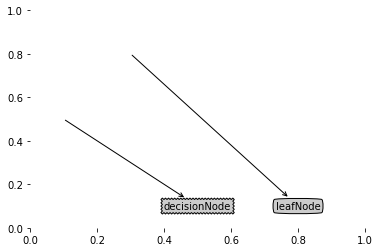

In [23]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")    #定义文本框和箭头格式
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeText, centerPt, parentPt, nodeType): #绘制带箭头的注解
    createPlot.ax1.annotate(nodeText, xy=parentPt, xycoords="axes fraction", xytext=centerPt, textcoords="axes fraction",
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)
    
def createPlot():
    fig = plt.figure(1, facecolor="white")
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode("decisionNode", (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode("leafNode", (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()
    
createPlot()

## 2.2 构造注解树

获取叶节点的数目和树的层数：

In [24]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]) == dict:           #测试节点的数据类型是否为字典
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]) == dict:
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        maxDepth = max(maxDepth, thisDepth)
    return maxDepth

def retrieveTree(i):
    listOfTrees = [{'no surfacing':{0:'no', 1:{'flippers': {0:'no', 1:'yes'}}}},
                   {'no surfacing':{0:'no', 1:{'flippers': {0:{'head':{0:'no', 1:'yes'}}, 1:'no'}}}} ]
    return listOfTrees[i]

retrieveTree(1)

{'no surfacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}

In [25]:
myTree = retrieveTree(0)
getNumLeafs(myTree)

3

In [26]:
getTreeDepth(myTree)

2

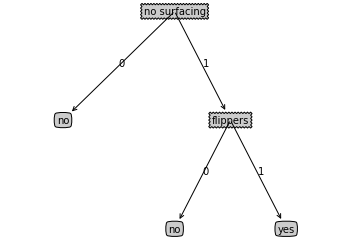

In [28]:
def plotMidText(cntrPt, parentPt, txtSpring):           #在父子节点间填充文本信息
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    ymid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, ymid, txtSpring)
    
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)                      #计算宽与高
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)              #标记子节点属性值
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD #减少y偏移
    for key in secondDict.keys():
        if type(secondDict[key]) == dict:
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()    
    
myTree = retrieveTree(0)
createPlot(myTree)

In [29]:
myTree['no surfacing'][3] = 'maybe'
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}

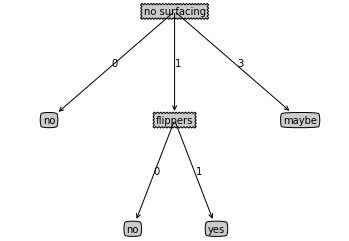

In [30]:
createPlot(myTree)

# 3. 测试和存储分类器

## 3.1 测试算法：使用决策树执行分类

In [31]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]) == dict:
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

myDat, labels = createDataSet()
labels

['no surfacing', 'flippers']

In [32]:
myTree = retrieveTree(0)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [33]:
classify(myTree, labels, [1, 0])

'no'

In [34]:
classify(myTree, labels, [1, 1])

'yes'

## 3.2 使用算法：决策树的存储

使用pickle模块存储决策树：

In [35]:
import pickle

def storeTree(inputTree, filename):
    with open(filename, 'wb') as fw:
        pickle.dump(inputTree, fw)

def grabTree(filename):
    with open(filename, 'rb') as fr:
        return pickle.load(fr)

storeTree(myTree, 'classifierStorage.txt')
grabTree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# 4. 示例：使用决策树预测隐形眼镜类型

使用决策树预测隐形眼镜类型：

（1）收集数据：提供的文本文件

（2）准备数据：解析tab键分隔的数据行

（3）分析数据：快速检查数据，确保正确地解析数据内容，使用createPlot()函数绘制最终的树形图

（4）训练算法：使用3.1节的createTree()函数

（5）测试算法：编写测试函数验证决策树可以正确分类给定的数据实例

（6）使用算法：存储树的数据结构，以便下次使用时无需重新构造树

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'no': {'age': {'pre': 'soft', 'young': 'soft', 'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}}}, 'yes': {'prescript': {'myope': 'hard', 'hyper': {'age': {'pre': 'no lenses', 'young': 'hard', 'presbyopic': 'no lenses'}}}}}}}}


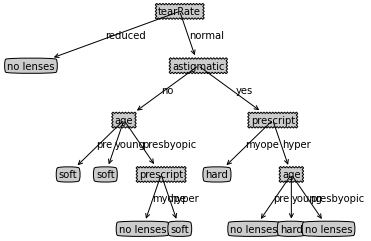

In [37]:
with open('lenses.txt') as fr:
    lenses = [inst.strip().split('\t') for inst in fr.readlines()]
    lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
    lensesTree = createTree(lenses, lensesLabels)
    print(lensesTree)
    createPlot(lensesTree)